# Dataset Preparation

# Imports

In [ ]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Resize, InterpolationMode
from torchsummary import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchaudio.transforms import MelSpectrogram
import librosa
import wandb
from tqdm import tqdm
import os


# Helper functions

In [36]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

def plot_history(history, net_name):
    x_ticks = range(1, len(history['train']['loss']) + 1)
    for item in history['train'].keys():
        plt.figure(figsize=(12, 4))
        for prefix, color in zip(['train', 'val'], ['r', 'b']):
            plt.plot(x_ticks, history[prefix][item], c=color, alpha=0.75, linestyle='--',
                     label=prefix)
        plt.title('{} {}'.format(net_name, item))
        plt.xlabel('Epoch')
        plt.xticks(x_ticks)
        plt.ylabel(item)
        plt.grid()
        plt.legend()
        plt.show()

def plot_metric_values(metric_values, net_name):
    for item in metric_values:
        fig, ax = plt.subplots(figsize=(12, 4))
        x = range(metric_values[item].shape[0])
        mean = metric_values[item].mean()
        bars = ax.bar(x, metric_values[item])
        
        ax.axhline(mean, color='r', linestyle=':')
        for bar in bars:
            height = bar.get_height()
            
            ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.2}'.format(height),
                    ha='center', va='bottom')
        ax.set_xlabel('Class')
        ax.set_xticks(x)
        ax.set_title('{} {} on test'.format(net_name, item))
        plt.show()

# Load dataset

In [45]:
class LoadedSpectrogramDataset(Dataset):
    """
    A PyTorch Dataset to load processed spectrogram tensors saved in
    a directory structure like:
    base_dir/
    ├── class_label_1/
    │   ├── file1.pt
    │   ├── file2.pt
    │   └── ...
    ├── class_label_2/
    │   ├── fileA.pt
    │   └── ...
    └── ...
    """
    def __init__(self, data_base_dir: str):
        """
        Args:
            data_base_dir: The path to the base directory containing the class subdirectories
                           with saved .pt files (e.g., 'RawFreqMasking').
        """
        self.data_base_dir = data_base_dir
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        self._load_files()

    def _load_files(self):
        """Scans the data_base_dir to find all .pt files and their class labels."""
        print(f"Scanning directory: {os.path.abspath(self.data_base_dir)}")

        # Get a list of potential class directories (first level subdirectories)
        class_dirs = [d for d in os.listdir(self.data_base_dir)
                      if os.path.isdir(os.path.join(self.data_base_dir, d))]

        # Sort class directories to ensure consistent class_to_idx mapping
        class_dirs.sort()

        # Create class_to_idx and idx_to_class mappings
        for idx, class_name in enumerate(class_dirs):
            self.class_to_idx[class_name] = idx
            self.idx_to_class[idx] = class_name

        print(f"Found {len(class_dirs)} classes: {list(self.class_to_idx.keys())}")

        # Iterate through class directories and find all .pt files
        for class_name in tqdm(class_dirs, desc="Loading file paths"):
            class_dir_path = os.path.join(self.data_base_dir, class_name)
            class_label_int = self.class_to_idx[class_name]

            # List all files in the class directory
            files_in_class_dir = os.listdir(class_dir_path)

            # Filter for .pt files and store their full paths and integer labels
            for filename in files_in_class_dir:
                if filename.endswith('.pt'):
                    file_path = os.path.join(class_dir_path, filename)
                    # Store (full_file_path, integer_class_label)
                    self.samples.append((file_path, class_label_int))

        print(f"Total files found: {len(self.samples)}")


    def __getitem__(self, idx):
        """
        Loads and returns a single sample from the dataset.

        Args:
            idx: The index of the sample to retrieve.

        Returns:
            A tuple containing:
            - specgram: The loaded spectrogram tensor (torch.Tensor).
            - class_label: The integer class label (int).
        """
        if idx >= len(self):
            raise IndexError("Index out of bounds")

        file_path, class_label_int = self.samples[idx]

        try:
            # Load the tensor from the .pt file
            specgram = torch.load(file_path)

            return specgram, class_label_int

        except Exception as e:
            print(f"Error loading sample {file_path}: {e}")

            # Let's return None and require manual handling in the DataLoader loop
            return None, None


    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.samples)

In [58]:
ds = LoadedSpectrogramDataset('../dataset/BilateralWithDataAugmentation')
n_classes = len(ds.class_to_idx.keys())
print(f"Loaded dataset contains {len(ds)} samples")
print(f"Number of classes: {n_classes}")
sample = ds[12304]
print(f"Sample shape: {sample[0].shape} class: {sample[1]}")

Scanning directory: /Users/bitfalt/Developer/IA-Project2/dataset/BilateralWithDataAugmentation
Found 10 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Loading file paths: 100%|██████████| 10/10 [00:00<00:00, 54.20it/s]

Total files found: 30000
Loaded dataset contains 30000 samples
Number of classes: 10
Sample shape: torch.Size([1, 24, 48]) class: 4


# Create dataset

In [59]:
n_channels = 1
n_mels = 24
time = 48

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST)
)

In [60]:
batch_size = 64

train_ds, val_ds, test_ds = random_split(ds, [0.7, 0.15, 0.15])

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

# Model A (LeNet5)

In [61]:
class LeNet5(torch.nn.Sequential):
    def __init__(self, n_channels, n_classes):
        super().__init__(
            torch.nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=432, out_features=120),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Linear(in_features=84, out_features=n_classes)
        )

In [62]:
net = LeNet5(n_channels=n_channels, n_classes=n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

summary(net, (n_channels, n_mels, time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 20, 44]             156
         AvgPool2d-2            [-1, 6, 10, 22]               0
            Conv2d-3            [-1, 16, 6, 18]           2,416
         AvgPool2d-4             [-1, 16, 3, 9]               0
           Flatten-5                  [-1, 432]               0
            Linear-6                  [-1, 120]          51,960
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 65,546
Trainable params: 65,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.25
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [72]:
run = wandb.init(
    entity="bitfalt-itcr",
    project="test-wandb",
    config={
        "learning_rate": 0.0001,
    },
    tags=["Model A", "LeNet5", "MNIST Audio", "Bilateral", "With Data Augmentation"],
    notes="Run with test and val metrics"
)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇██
Train Loss,█▆▆▆▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train accuracy,▁▃▅▅▆▆▇▇▇▇█████
Train f1-score,▁▃▅▅▆▇▇▇▇▇█████
Train precision,▁▃▅▆▆▇▇▇▇▇█████
Train recall,▁▃▅▅▆▆▇▇▇▇█████
Val Loss,███▅▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Val accuracy,▁▂▄▅▅▅▅▆▆▇▇▇▇██
Val f1-score,▁▂▄▆▅▅▅▆▆▇▇▇▇██
Val precision,▁▁▄▆▅▅▅▆▆▇▇▇▇██
Val recall,▁▂▄▅▅▅▅▆▆▇▇▇▇██


In [73]:
def eval(net, eval_dl, prefix, criterion, metrics, device):
    eval_loss = torch.tensor(0.0).to(device)
    eval_metric_values = {
        metric: torch.zeros(metrics[metric].num_classes if metrics[metric].average is None
                            else 1).to(device) for metric in metrics
    }
    
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in eval_dl:
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)
            
            eval_loss += loss.detach().cpu() * eval_dl.batch_size
            for metric in metrics:
                eval_metric_values[metric] += metrics[metric](preds, y) * \
                    eval_dl.batch_size
    
    eval_loss /= len(eval_dl.dataset)
    for metric in metrics:
        eval_metric_values[metric] /= len(eval_dl.dataset)
    
    print('{}_loss: {:.3f}'.format(prefix, eval_loss), end='')
    for metric in metrics:
        print(', {}_{}: {:.3f}'.format(prefix, metric, eval_metric_values[metric].mean()),
              end='')
        
        if prefix == 'test':
            lossKey = f"{prefix} Loss"
            metricKey = f"{prefix} {metric}"
            wandb.log({
                lossKey: eval_loss,
                metricKey: eval_metric_values[metric].mean(),
            })
    
    return eval_loss, eval_metric_values

In [74]:
def train(net, train_dl, val_dl, n_epochs, criterion, metrics, device, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {
        'train': {'loss': []} | {metric: [] for metric in metrics},
        'val': {'loss': []} | {metric: [] for metric in metrics}
    }
    
    net.to(device)
    for epoch in range(n_epochs):
        train_loss = torch.tensor(0.0).to(device)
        train_metric_values = {
            metric: torch.tensor(0.0).to(device) for metric in metrics
        }
        
        net.train()
        for X, y in tqdm(train_dl, desc='Epoch {}/{}'.format(epoch + 1, n_epochs),
                         total=len(train_dl)):
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss.detach().cpu() * train_dl.batch_size
                for metric in metrics:
                    train_metric_values[metric] += train_dl.batch_size * \
                        metrics[metric](preds, y)
        
        train_loss /= len(train_dl.dataset)
        for metric in metrics:
            train_metric_values[metric] /= len(train_dl.dataset)
        
        print('train_loss: {:.3f}'.format(train_loss), end=', ')
        for metric in metrics:
            print('train_{}: {:.3f}'.format(metric, train_metric_values[metric]),
                  end=', ')

            wandb.log({
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Train " + metric: train_metric_values[metric],
            })
        
        history['train']['loss'].append(train_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['train'][metric].append(train_metric_values[metric].cpu().detach() \
                                            .numpy().item())
            
        val_loss, val_metric_values = eval(net, val_dl, prefix='val', criterion=criterion,
                                           metrics=metrics, device=device)
        
        scheduler.step(val_loss)
        
        history['val']['loss'].append(val_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['val'][metric].append(val_metric_values[metric].cpu().detach() \
                                          .numpy().item())
            wandb.log({
                "Epoch": epoch,
                "Val Loss": val_loss,
                "Val " + metric: val_metric_values[metric],
            })
            
    return history

In [75]:
criterion = torch.nn.CrossEntropyLoss()

train_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average='macro').to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average='macro').to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average='macro').to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average='macro').to(device)
}

In [76]:
history = train(net, train_dl, val_dl, n_epochs=15, criterion=criterion,
                metrics=train_metrics, device=device, lr=0.0001)

Epoch 1/15: 100%|██████████| 329/329 [00:09<00:00, 34.03it/s]


train_loss: 0.969, train_accuracy: 0.787, train_precision: 0.797, train_recall: 0.787, train_f1-score: 0.773, val_loss: 1.089, val_accuracy: 0.787, val_precision: 0.802, val_recall: 0.787, val_f1-score: 0.774

Epoch 2/15: 100%|██████████| 329/329 [00:07<00:00, 44.66it/s]


train_loss: 0.942, train_accuracy: 0.781, train_precision: 0.793, train_recall: 0.781, train_f1-score: 0.767, val_loss: 1.070, val_accuracy: 0.801, val_precision: 0.817, val_recall: 0.801, val_f1-score: 0.788

Epoch 3/15: 100%|██████████| 329/329 [00:07<00:00, 45.35it/s]


train_loss: 0.946, train_accuracy: 0.790, train_precision: 0.799, train_recall: 0.790, train_f1-score: 0.775, val_loss: 1.079, val_accuracy: 0.802, val_precision: 0.816, val_recall: 0.802, val_f1-score: 0.790

Epoch 4/15: 100%|██████████| 329/329 [00:06<00:00, 47.82it/s]


train_loss: 0.928, train_accuracy: 0.796, train_precision: 0.805, train_recall: 0.796, train_f1-score: 0.782, val_loss: 1.083, val_accuracy: 0.813, val_precision: 0.823, val_recall: 0.813, val_f1-score: 0.801

Epoch 5/15: 100%|██████████| 329/329 [00:06<00:00, 49.13it/s]


train_loss: 0.916, train_accuracy: 0.796, train_precision: 0.804, train_recall: 0.796, train_f1-score: 0.783, val_loss: 1.111, val_accuracy: 0.795, val_precision: 0.810, val_recall: 0.795, val_f1-score: 0.782

Epoch 6/15: 100%|██████████| 329/329 [00:06<00:00, 49.31it/s]


train_loss: 0.901, train_accuracy: 0.797, train_precision: 0.809, train_recall: 0.797, train_f1-score: 0.785, val_loss: 1.077, val_accuracy: 0.809, val_precision: 0.819, val_recall: 0.809, val_f1-score: 0.796

Epoch 7/15: 100%|██████████| 329/329 [00:07<00:00, 46.67it/s]


train_loss: 0.896, train_accuracy: 0.798, train_precision: 0.806, train_recall: 0.798, train_f1-score: 0.785, val_loss: 1.063, val_accuracy: 0.808, val_precision: 0.817, val_recall: 0.808, val_f1-score: 0.796

Epoch 8/15: 100%|██████████| 329/329 [00:07<00:00, 42.17it/s]


train_loss: 0.884, train_accuracy: 0.800, train_precision: 0.804, train_recall: 0.800, train_f1-score: 0.784, val_loss: 1.093, val_accuracy: 0.806, val_precision: 0.817, val_recall: 0.806, val_f1-score: 0.793

Epoch 9/15: 100%|██████████| 329/329 [00:07<00:00, 42.66it/s]


train_loss: 0.884, train_accuracy: 0.803, train_precision: 0.808, train_recall: 0.803, train_f1-score: 0.788, val_loss: 1.043, val_accuracy: 0.812, val_precision: 0.819, val_recall: 0.812, val_f1-score: 0.801

Epoch 10/15: 100%|██████████| 329/329 [00:07<00:00, 45.59it/s]


train_loss: 0.880, train_accuracy: 0.800, train_precision: 0.809, train_recall: 0.800, train_f1-score: 0.788, val_loss: 1.078, val_accuracy: 0.798, val_precision: 0.809, val_recall: 0.798, val_f1-score: 0.785

Epoch 11/15: 100%|██████████| 329/329 [00:07<00:00, 44.03it/s]


train_loss: 0.874, train_accuracy: 0.806, train_precision: 0.812, train_recall: 0.806, train_f1-score: 0.792, val_loss: 1.064, val_accuracy: 0.799, val_precision: 0.808, val_recall: 0.799, val_f1-score: 0.786

Epoch 12/15: 100%|██████████| 329/329 [00:07<00:00, 44.47it/s]


train_loss: 0.870, train_accuracy: 0.804, train_precision: 0.810, train_recall: 0.804, train_f1-score: 0.792, val_loss: 1.051, val_accuracy: 0.810, val_precision: 0.816, val_recall: 0.810, val_f1-score: 0.797

Epoch 13/15: 100%|██████████| 329/329 [00:07<00:00, 44.91it/s]


train_loss: 0.853, train_accuracy: 0.804, train_precision: 0.810, train_recall: 0.804, train_f1-score: 0.791, val_loss: 1.047, val_accuracy: 0.809, val_precision: 0.820, val_recall: 0.809, val_f1-score: 0.797

Epoch 14/15: 100%|██████████| 329/329 [00:07<00:00, 42.45it/s]


train_loss: 0.856, train_accuracy: 0.806, train_precision: 0.811, train_recall: 0.806, train_f1-score: 0.792, val_loss: 1.050, val_accuracy: 0.812, val_precision: 0.822, val_recall: 0.812, val_f1-score: 0.800

Epoch 15/15: 100%|██████████| 329/329 [00:08<00:00, 40.58it/s]


train_loss: 0.853, train_accuracy: 0.805, train_precision: 0.813, train_recall: 0.805, train_f1-score: 0.792, val_loss: 1.049, val_accuracy: 0.814, val_precision: 0.823, val_recall: 0.814, val_f1-score: 0.802

# Plot history

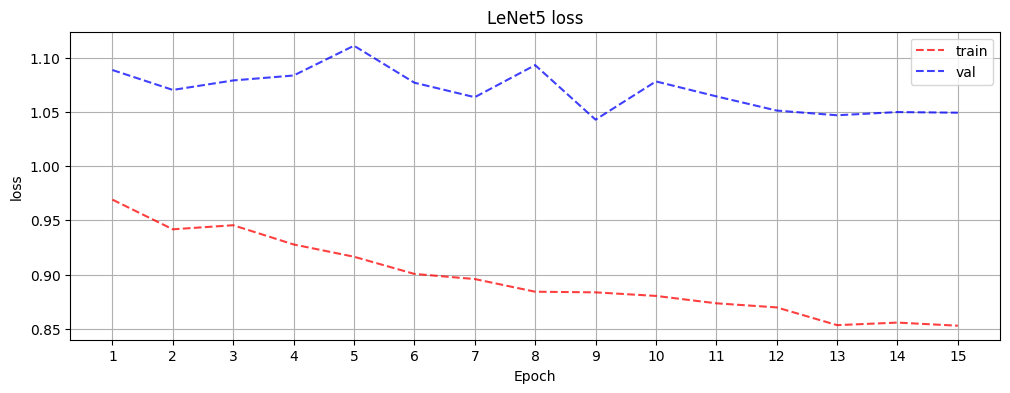

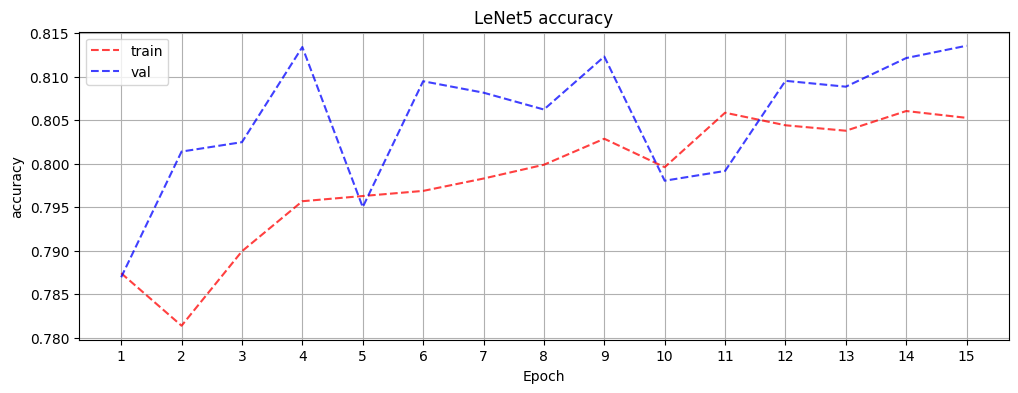

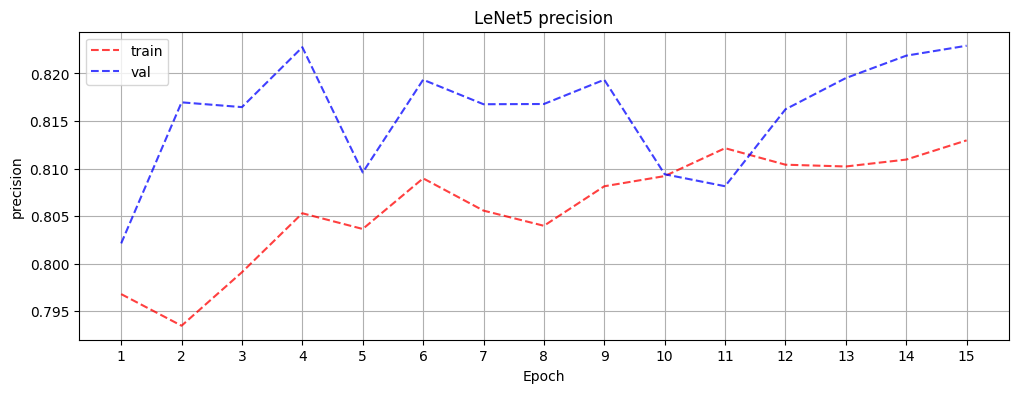

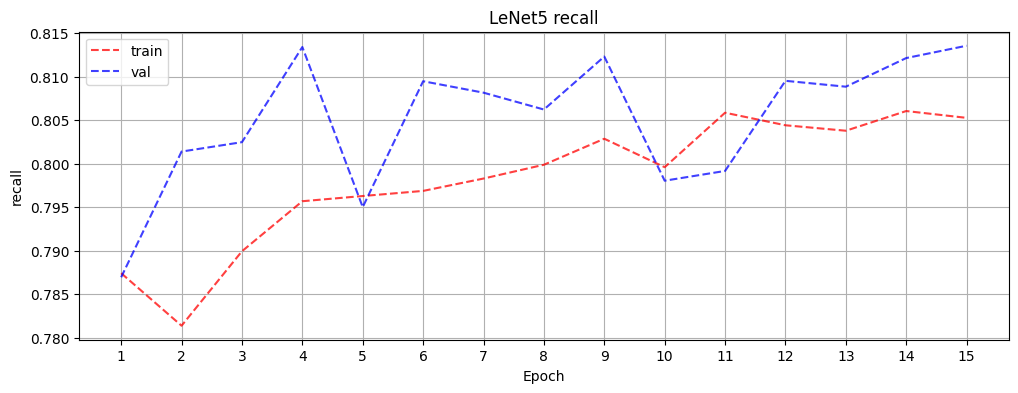

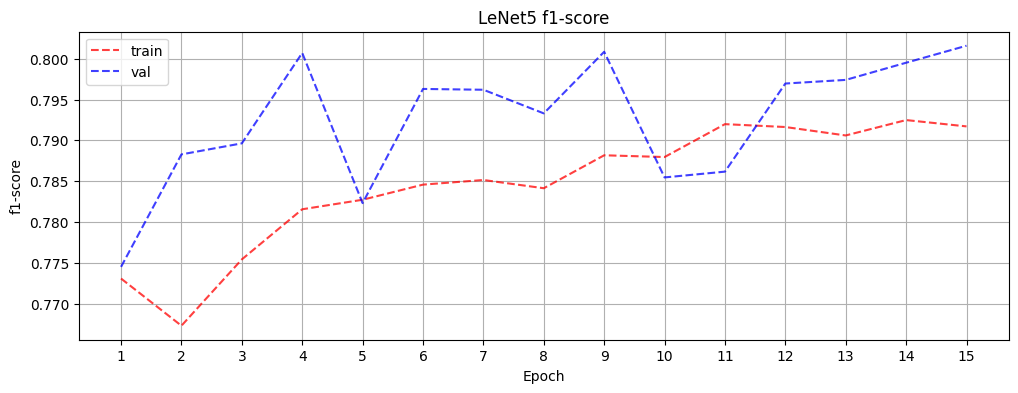

In [81]:
plot_history(history, net_name='LeNet5')


# Evaluate neural network

In [78]:
test_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average=None).to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average=None).to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average=None).to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average=None).to(device)
}

In [79]:
_, test_metric_values = eval(net, test_dl, prefix='test', criterion=criterion,
                             metrics=test_metrics, device=device)

test_loss: 0.864, test_accuracy: 0.806, test_precision: 0.817, test_recall: 0.806, test_f1-score: 0.794

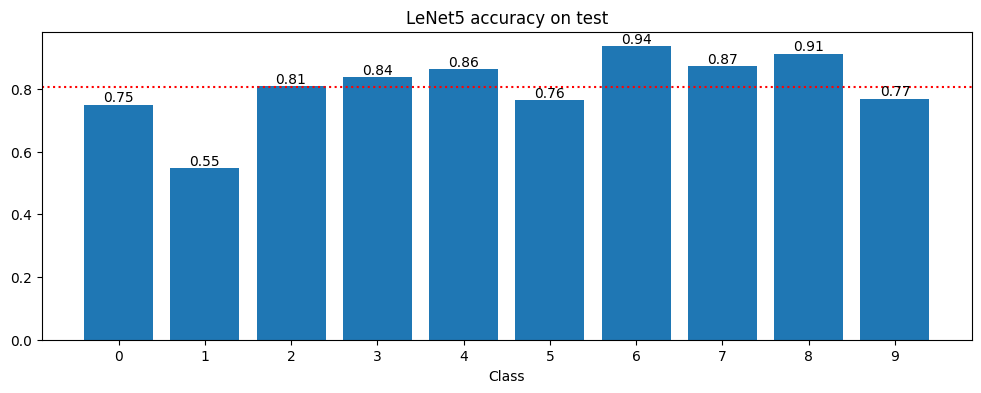

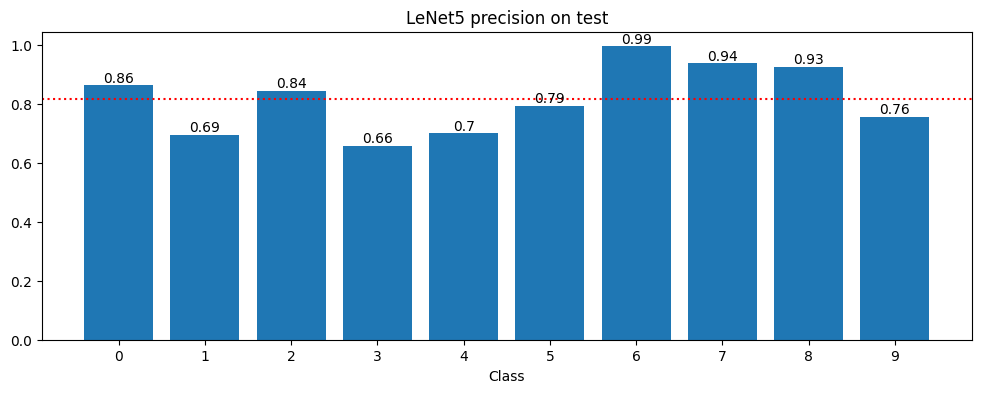

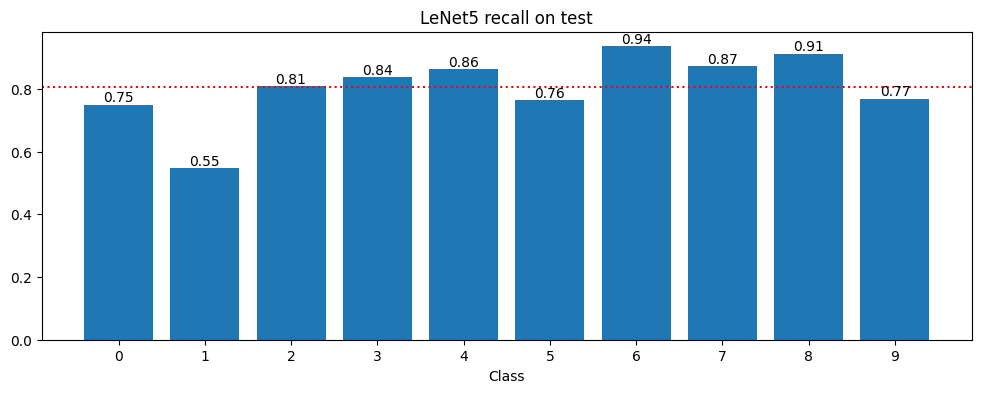

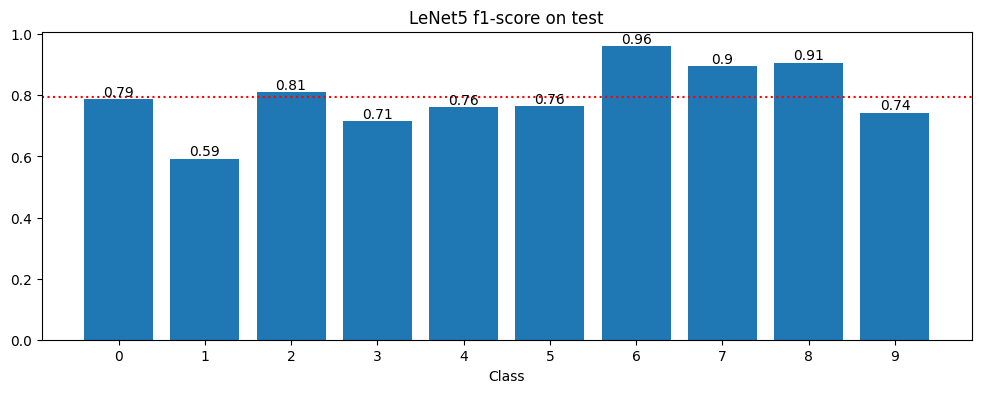

In [80]:
plot_metric_values(test_metric_values, net_name='LeNet5')